In [65]:
from scipy import signal
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import os

In [66]:
# adaptive weighted-edge linear interpolation
# grbg format

def Reflective_Padding(img):
    """
    Reflective padding for 3*3 kernel convolution
    """
    length = img.shape[0]
    width = img.shape[1]
    padded_length = length + 2
    padded_width = width + 2
    
    padded_img = np.zeros((padded_length, padded_width))
    padded_img[1:padded_length-1, 1:padded_width-1] = img
    padded_img[0, 1:padded_width-1] = padded_img[2, 1:padded_width-1]
    padded_img[padded_length-1, 1:padded_width-1] = padded_img[padded_length-3, 1:padded_width-1]
    padded_img[:, 0] = padded_img[:, 2]
    padded_img[:, padded_width-1] = padded_img[:, padded_width-3]
    
    return padded_img
    

def Local_Gradients(padded_img):
    """
    Calculate local gradients in 4 directions.
    """
    padded_length = padded_img.shape[0]
    padded_width = padded_img.shape[1]
    
    # gradient matrices
    x_grad = np.zeros((padded_length, padded_width)) # horizontal direction
    y_grad = np.zeros((padded_length, padded_width)) # vertical direction
    d_grad = np.zeros((padded_length, padded_width)) # main diagonal direction
    a_grad = np.zeros((padded_length, padded_width)) # anti-diagonal direction
    
    # calculate internal elements
    for i in range(1, padded_length-1):
        for j in range(1, padded_width-1):
            x_grad[i][j] = (padded_img[i][j+1] - padded_img[i][j-1]) / 2
            y_grad[i][j] = (padded_img[i-1][j] - padded_img[i+1][j]) / 2
            if (i + j) % 2 == 0: # at G locations
                d_grad[i][j] = max(
                    abs(padded_img[i-1][j-1]-padded_img[i][j]), abs(padded_img[i+1][j+1]-padded_img[i][j])
                ) / (2**0.5)
                a_grad[i][j] = max(
                    abs(padded_img[i-1][j+1]-padded_img[i][j]), abs(padded_img[i+1][j-1]-padded_img[i][j])
                ) / (2**0.5)
            else: # other locations
                d_grad[i][j] = (padded_img[i-1][j-1] - padded_img[i+1][j+1]) / (2 * 2**0.5)
                a_grad[i][j] = (padded_img[i-1][j+1] - padded_img[i+1][j-1]) / (2 * 2**0.5)
            
    # padding for edge elements
    x_grad = Reflective_Padding(x_grad[1:padded_length-1, 1:padded_width-1]) 
    y_grad = Reflective_Padding(y_grad[1:padded_length-1, 1:padded_width-1])
    d_grad = Reflective_Padding(d_grad[1:padded_length-1, 1:padded_width-1])
    a_grad = Reflective_Padding(a_grad[1:padded_length-1, 1:padded_width-1])
    
    return x_grad, y_grad, d_grad, a_grad


def Weight_Function(grad1, grad2):
    """
    Calculate the weight between two local gradients.
    """
    return 1 / (1 + grad1 ** 2 + grad2 ** 2) ** 0.5


def Weight_Map(padded_img):
    """
    Calculate weight map in 4 directions.
    """
    padded_length = padded_img.shape[0]
    padded_width = padded_img.shape[1]

    # calculate local gradients in 4 directions
    x_grad, y_grad, d_grad, a_grad = Local_Gradients(padded_img)
    
    # weight matrices
    x_weight = np.zeros((padded_length, padded_width)) # horizontal (with the neighbor on its right)
    y_weight = np.zeros((padded_length, padded_width)) # vertical (with the neighbor below)
    d_weight = np.zeros((padded_length, padded_width)) # main diagonal (with the neighbor in the bottom-right direction)
    a_weight = np.zeros((padded_length, padded_width)) # anti-diagonal (with the neighbor in the bottom-left direction)

    # calculate weights
    x_weight[:,:padded_width-1] = Weight_Function(x_grad[:,:padded_width-1], x_grad[:,1:padded_width])
    y_weight[:padded_length-1,:] = Weight_Function(y_grad[:padded_length-1,:], y_grad[1:padded_length,:])
    d_weight[:padded_length-1,:padded_width-1] = Weight_Function(
        d_grad[:padded_length-1,:padded_width-1], d_grad[1:padded_length,1:padded_width])
    a_weight[:padded_length-1,1:padded_width] = Weight_Function(
        a_grad[:padded_length-1,1:padded_width], a_grad[1:padded_length,:padded_width-1])
    
    return x_weight, y_weight, d_weight, a_weight


def kernelG(i, j, x_weight, y_weight):
    """
    Calculate a weighted convolution kernel for G interpolation.
    i, j are indexes of the up-left element of the kernel.
    """
    weight1 = y_weight[i][j+1]
    weight2 = x_weight[i+1][j]
    weight3 = x_weight[i+1][j+1]
    weight4 = y_weight[i+1][j+1]
    
    kernel = np.array(
        [[0, weight1, 0], [weight2, 0, weight3], [0, weight4, 0]]
    )
    return kernel / kernel.sum()


def kernelXY(i, j, x_weight, y_weight, G_pad):
    """
    Calculate a weighted convolution kernel of x,y direction neighbors.
    i, j are indexes of the up-left element of the kernel.
    """
    weight1 = y_weight[i][j+1]
    weight2 = x_weight[i+1][j]
    weight3 = x_weight[i+1][j+1]
    weight4 = y_weight[i+1][j+1]

    block = G_pad[i:i+3, j:j+3]
    block[block==0.0] = 1e-7
    
    kernel = np.array(
        [[0, weight1 / block[0][1], 0], 
         [weight2 / block[1][0], 0, weight3 / block[1][2]], 
         [0, weight4 / block[2][1], 0]]
    )
    return kernel / kernel.sum()

    
def kernelDA(i, j, d_weight, a_weight, G_pad):
    """
    Calculate a weighted convolution kernel of diagonal/anti-diagonal neighbors.
    i, j are indexes of the up-left element of the kernel.
    """
    weight1 = d_weight[i][j]
    weight2 = a_weight[i][j+2]
    weight3 = a_weight[i+1][j+1]
    weight4 = d_weight[i+1][j+1]

    block = G_pad[i:i+3, j:j+3]
    block[block==0.0] = 1e-7
    
    kernel = np.array(
        [[weight1 / block[0][0], 0, weight2 / block[0][2]], 
         [0, 0, 0], 
         [weight3 / block[2][0], 0, weight4 / block[2][2]]]
    )
    return kernel / kernel.sum()


def kernelC(i, j, x_weight, y_weight, d_weight, a_weight, channel):
    """
    Calculate a kernel for the correction steps.
    i, j are indexes of the up-left element of the kernel.
    """
    weight1 = d_weight[i][j]
    weight2 = y_weight[i][j+1]
    weight3 = a_weight[i][j+2]
    weight4 = x_weight[i+1][j]
    weight5 = x_weight[i+1][j+1]
    weight6 = a_weight[i+1][j+1]
    weight7 = y_weight[i+1][j+1]
    weight8 = d_weight[i+1][j+1]

    block = channel[i:i+3, j:j+3]
    block[block==0.0] = 1e-7

    kernel = np.array(
        [[weight1, weight2, weight3],
         [weight4, 0, weight5],
         [weight6, weight7, weight8]]
    ) / block

    return kernel / kernel.sum()


def Weighted_Linear_Demosaicing(img, refinement=False):
    """
    The demosaicing algorithm of adaptive weighted-edge linear interpolation (Kimmel, 1999).
    """
    length = img.shape[0]
    width = img.shape[1]
    
    # add padding to img for edge calculation
    padded_img = Reflective_Padding(img)
    
    # calculate weight maps
    x_weight, y_weight, d_weight, a_weight = Weight_Map(padded_img)
    
    # calculate R, G, B:
    R = np.zeros((length, width)).astype('float32')
    G = np.zeros((length, width)).astype('float32')
    B = np.zeros((length, width)).astype('float32')
    
    # step 1: G interpolation
    for i in range(length):
        for j in range(width):
            if i % 2 == j % 2:
                G[i][j] = img[i][j]
            else:
                G_conv = kernelG(i, j, x_weight, y_weight)
                G[i][j] = signal.convolve2d(padded_img[i:i+3, j:j+3], G_conv, 'valid')[0][0]   
    
    # step 2: R, B interpolation at R, B locations (using Step 1 results)
    G_pad = Reflective_Padding(G)
    for i in range(length):
        for j in range(width): 
            if i % 2 != j % 2: 
                DA_conv = kernelDA(i, j, d_weight, a_weight, G_pad)
                if i % 2 == 0: # R location
                    R[i][j] = img[i][j]
                    B[i][j] = signal.convolve2d(padded_img[i:i+3, j:j+3], DA_conv, 'valid')[0][0]
                else: # B location
                    R[i][j] = signal.convolve2d(padded_img[i:i+3, j:j+3], DA_conv, 'valid')[0][0]
                    B[i][j] = img[i][j]
         
    # step 3: R, B interpolation at G locations (using Step 1 and 2 results)
    R_pad = Reflective_Padding(R)
    B_pad = Reflective_Padding(B)
    for i in range(length):
        for j in range(width):
            if i % 2 == j % 2:
                XY_conv = kernelXY(i, j, x_weight, y_weight, G_pad)
                R[i][j] = signal.convolve2d(R_pad[i:i+3, j:j+3], XY_conv, 'valid')[0][0]
                B[i][j] = signal.convolve2d(B_pad[i:i+3, j:j+3], XY_conv, 'valid')[0][0]

    # optional steps
    if (refinement == True):
        # step 4: refinement iteration
        G_pad = Reflective_Padding(G)
        for n in range(3):
            # G correction
            R_pad = Reflective_Padding(R)
            B_pad = Reflective_Padding(B)
            for i in range(length):
                for j in range(width):
                    if i % 2 != j % 2:
                        R_conv = kernelC(i, j, x_weight, y_weight, d_weight, a_weight, R_pad)
                        B_conv = kernelC(i, j, x_weight, y_weight, d_weight, a_weight, B_pad)
                        GR = signal.convolve2d(G_pad[i:i+3, j:j+3], R_conv, 'valid')[0][0]
                        GB = signal.convolve2d(G_pad[i:i+3, j:j+3], B_conv, 'valid')[0][0]
                        G[i][j] = 0.5 * (GR + GB)

            # R, B correction
            G_pad = Reflective_Padding(G)
            for i in range(length):
                for j in range(width):
                    if i % 2 == j % 2:
                        C_conv = kernelC(i, j, x_weight, y_weight, d_weight, a_weight, G_pad)
                        R[i][j] = signal.convolve2d(R_pad[i:i+3, j:j+3], C_conv, 'valid')[0][0]
                        B[i][j] = signal.convolve2d(B_pad[i:i+3, j:j+3], C_conv, 'valid')[0][0]
    
    # get a 3D output image
    img_d = np.zeros((length, width, 3))
    img_d[:, :, 0] = R
    img_d[:, :, 1] = G
    img_d[:, :, 2] = B
    
    return img_d

In [67]:
# calculate psnr

def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    else:
        return 20 * np.log10(255 / np.sqrt(mse))

4.png after demosaicing:
7.png after demosaicing:
11.png after demosaicing:
2.png after demosaicing:
3.png after demosaicing:
1.png after demosaicing:
15.png after demosaicing:
10.png after demosaicing:
14.png after demosaicing:
5.png after demosaicing:
6.png after demosaicing:
17.png after demosaicing:
9.png after demosaicing:
18.png after demosaicing:
8.png after demosaicing:
13.png after demosaicing:
16.png after demosaicing:
12.png after demosaicing:


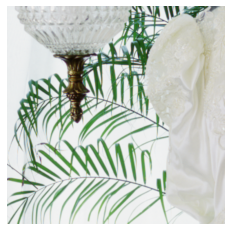

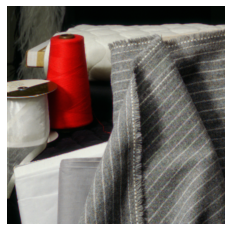

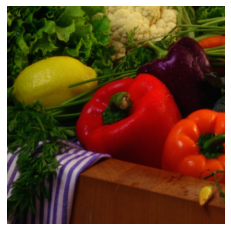

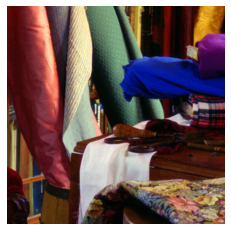

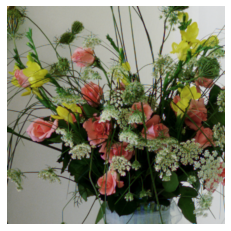

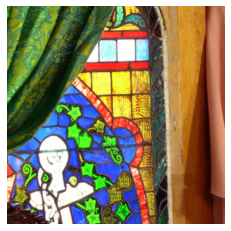

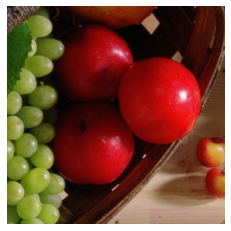

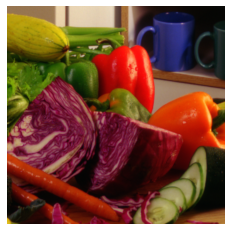

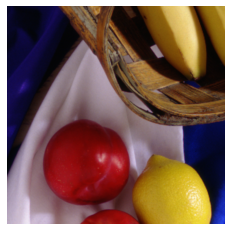

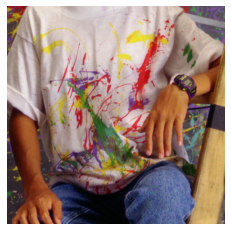

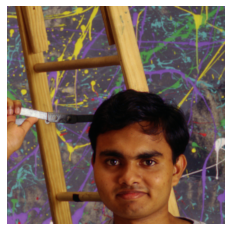

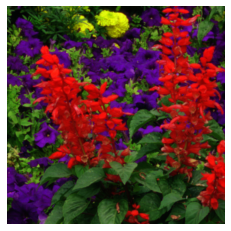

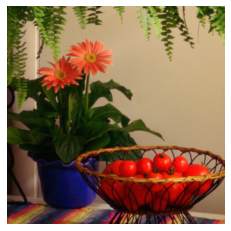

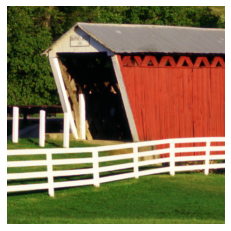

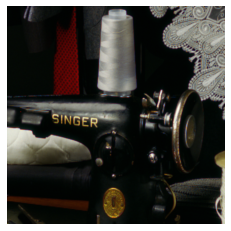

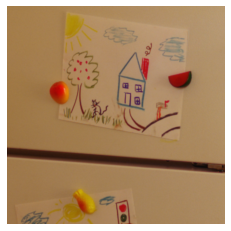

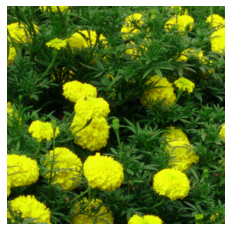

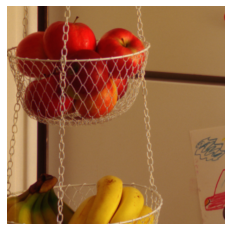

In [68]:
# process inputs

# path = "/Users/qiaowenyang/Desktop/22ss/jssxx/labs/Codingproject/code/inputs"
path = "/home/brighterw/PHOT22spr/coding_pj/Demosaicing/inputs"
truth = "/home/brighterw/PHOT22spr/coding_pj/Demosaicing/ground_truth"

psnr = {}

def process(path):
    for file in os.listdir(path):
        # the input file
        filename1 = os.path.join(path, file)
        img1 = imread(filename1).astype('float32')
        img_cfa = img1[:, :, 0] + img1[:, :, 1] + img1[:, :, 2]
        img_d = Weighted_Linear_Demosaicing(img_cfa / 255, refinement=False)
        # the ground truth file
        filename2 = os.path.join(path, file)
        img2 = imread(filename2).astype('float32')
        # calculate PSNR
        psnr[file] = PSNR(img_d * 255, img2)
        # show the output image
        print(f"{file} after demosaicing:")
        plt.figure()
        plt.imshow(img_d)
        plt.axis('off')
        plt.savefig(f"weighted_linear_outputs/demosaicing_{file}", dpi=200)

process(path)

In [69]:
# psnr result

import csv

f = open('psnr_kimmel.csv', 'w')

with f:
    fnames = ['filename', 'psnr']
    writer = csv.DictWriter(f, fieldnames=fnames)    
    writer.writeheader()
    for key, value in psnr.items():
        writer.writerow({'filename' : key, 'psnr': value})

print(psnr)

{'4.png': 3.8466466422581505, '7.png': 8.412578765834297, '11.png': 12.174350252544375, '2.png': 9.460314755002452, '3.png': 8.037455880360858, '1.png': 7.611704373189053, '15.png': 10.843141142524138, '10.png': 10.412093716927245, '14.png': 9.56492080650192, '5.png': 6.960916687049107, '6.png': 9.805765228479679, '17.png': 12.168488382149572, '9.png': 8.382186448202726, '18.png': 7.973319300828154, '8.png': 12.916594772346388, '13.png': 7.559492978572293, '16.png': 10.541750039749092, '12.png': 8.583748369822054}
